# Importing statements

In [ ]:
pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")
encoder = LabelEncoder()

# Census Income

In [3]:
 
census_income = fetch_ucirepo(id=20) 
  
# data (as pandas dataframes) 
census_X = census_income.data.features 
census_y = census_income.data.targets 

# Credit Card Clients

In [4]:
default_of_credit_card_clients = fetch_ucirepo(id=350) 
cc_X = default_of_credit_card_clients.data.features 
cc_y = default_of_credit_card_clients.data.targets

# Phishing

In [5]:
phishing_websites = fetch_ucirepo(id=327) 
phishing_X = phishing_websites.data.features 
phishing_y = phishing_websites.data.targets 


# MAGIC Gamma Telescope

In [6]:
magic_gamma_telescope = fetch_ucirepo(id=159)
telescope_X = magic_gamma_telescope.data.features 
telescope_y = magic_gamma_telescope.data.targets

# Data Cleaning

Census dataset

In [ ]:
census_X.dropna()
oneHot = OneHotEncoder(sparse_output=False, drop='first')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', oneHot, census_X.select_dtypes(include=['object']).columns)  
    ],
    remainder='passthrough'  
)
census_X = preprocessor.fit_transform(census_X)
census_y.dropna()
census_y = np.where((census_y['income'] == "<=50K") | (census_y['income'] == "<=50K."), 0, 1)

census_X

Credit Card dataset

In [8]:
cc_X.dropna()
cc_y = cc_y[~np.isnan(cc_y)]
cc_y =cc_y.values.ravel()

Phishing dataset

In [9]:
phishing_X.dropna()
phishing_y = phishing_y[~np.isnan(phishing_y)]
phishing_y = phishing_y.values.ravel()

Telescope dataset

In [10]:
telescope_X.dropna()
telescope_y = encoder.fit_transform(telescope_y)
telescope_y = telescope_y[~np.isnan(telescope_y)]
telescope_y = telescope_y.ravel()

# Using the models

In [ ]:
datasets = {
    'Credit Card': cc_X,
    'Census': census_X,
    'Phishing': phishing_X,
    'Magic GAMMA Telescope': telescope_X
}

param_grids = {
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "classifier__n_estimators": [10, 50, 100],
            "classifier__max_depth": [None, 5, 10],
            "classifier__min_samples_split": [2, 5, 10]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "classifier__n_neighbors": [5, 7, 9],
            "classifier__weights": ["uniform", "distance"],
            "classifier__metric": ["euclidean", "manhattan"]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "classifier__C": [0.1, 1, 10],
            "classifier__solver": ["lbfgs", "saga"],
            "classifier__penalty": ["l2", None]
        }
    },
    "Neural Network": {
        "model": MLPClassifier(),
        "params": {
            "classifier__hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "classifier__activation": ["relu", "tanh"],
            "classifier__learning_rate": ['constant'],
            "classifier__learning_rate_init": [0.1]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(),
        "params": {
            "classifier__n_estimators": [50, 100, 200],
            "classifier__learning_rate": [0.01, 0.1, 1,2.0]
        }
    }
}


splits = [0.2, 0.5, 0.8]
preprocessed_datasets = {}
preprocessed_datasets['Phishing'] = (phishing_X,phishing_y)
preprocessed_datasets['Telescope'] = (telescope_X,telescope_y)
preprocessed_datasets['Credit Cards'] = (cc_X,cc_y)
preprocessed_datasets['Census'] = (census_X,census_y)
results = []
detailed_results = []

for dataset_name, (X, y) in preprocessed_datasets.items():
    print(f"Processing {dataset_name}")
    for split in splits:
        print(f"Testing with split {split}")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
        
        for model_name, config in param_grids.items():
            print(f"Running GridSearch for {model_name}")

            pipeline = Pipeline([
                ('scaler', StandardScaler()),  
                ('classifier', config['model'])  
            ])
            
            grid_search = GridSearchCV(
                pipeline,
                param_grid=config['params'],
                scoring="accuracy",  
                cv=3,
                return_train_score= True 
            )
            
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            best_accuracy = grid_search.best_score_

            y_pred = best_model.predict(X_test)
            test_accuracy = accuracy_score(y_test, y_pred)

            results.append({
                "Dataset": dataset_name,
                "Split": split,
                "Model": model_name,
                "Best Parameters": best_params,
                "Best Cross-Validation Accuracy": best_accuracy,
                "Test Accuracy": test_accuracy
            })
            
            for i in range(len(grid_search.cv_results_['params'])):
                detailed_results.append({
                    "Dataset": dataset_name,
                    "Split": split,
                    "Model": model_name,
                    "Parameters": grid_search.cv_results_['params'][i],
                    "Mean Train Accuracy": grid_search.cv_results_['mean_train_score'][i],
                    "Mean Test Accuracy": grid_search.cv_results_['mean_test_score'][i],
                    "Rank Test Accuracy": grid_search.cv_results_['rank_test_score'][i]
                })


Processing Phishing
Testing with split 0.2
Running GridSearch for Random Forest
Running GridSearch for KNN
Running GridSearch for Logistic Regression
Running GridSearch for Neural Network
Running GridSearch for AdaBoost
Testing with split 0.5
Running GridSearch for Random Forest
Running GridSearch for KNN
Running GridSearch for Logistic Regression
Running GridSearch for Neural Network
Running GridSearch for AdaBoost
Testing with split 0.8
Running GridSearch for Random Forest
Running GridSearch for KNN
Running GridSearch for Logistic Regression
Running GridSearch for Neural Network
Running GridSearch for AdaBoost
Processing Telescope
Testing with split 0.2
Running GridSearch for Random Forest
Running GridSearch for KNN
Running GridSearch for Logistic Regression
Running GridSearch for Neural Network
Running GridSearch for AdaBoost
Testing with split 0.5
Running GridSearch for Random Forest
Running GridSearch for KNN
Running GridSearch for Logistic Regression
Running GridSearch for Neural

In [ ]:
results_df = pd.DataFrame(results)
results_df.head(20)

,Dataset,Split,Model,Best Parameters,Best Cross-Validation Accuracy,Test Accuracy
0,Phishing,0.2,Random Forest,"{'classifier__max_depth': None, 'classifier__m...",0.967775,0.965174
1,Phishing,0.2,KNN,"{'classifier__metric': 'manhattan', 'classifie...",0.961443,0.958842
2,Phishing,0.2,Logistic Regression,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.929557,0.923112
3,Phishing,0.2,Neural Network,"{'classifier__activation': 'relu', 'classifier...",0.953980,0.962008
4,Phishing,0.2,AdaBoost,"{'classifier__learning_rate': 1, 'classifier__...",0.937585,0.935776
5,Phishing,0.5,Random Forest,"{'classifier__max_depth': None, 'classifier__m...",0.961100,0.966172
6,Phishing,0.5,KNN,"{'classifier__metric': 'manhattan', 'classifie...",0.947529,0.956946
7,Phishing,0.5,Logistic Regression,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.928534,0.923661
8,Phishing,0.5,Neural Network,"{'classifier__activation': 'relu', 'classifier...",0.945179,0.951339
9,Phishing,0.5,AdaBoost,"{'classifier__learning_rate': 1, 'classifier__...",0.938304,0.937952


In [43]:
detailed_df = pd.DataFrame(detailed_results)
detailed_df.head(20)

,Dataset,Split,Model,Parameters,Mean Train Accuracy,Mean Test Accuracy,Rank Test Accuracy
0,Phishing,0.2,Random Forest,"{'classifier__max_depth': None, 'classifier__m...",0.990841,0.964043,5
1,Phishing,0.2,Random Forest,"{'classifier__max_depth': None, 'classifier__m...",0.991633,0.967662,2
2,Phishing,0.2,Random Forest,"{'classifier__max_depth': None, 'classifier__m...",0.991689,0.967775,1
3,Phishing,0.2,Random Forest,"{'classifier__max_depth': None, 'classifier__m...",0.984679,0.959747,7
4,Phishing,0.2,Random Forest,"{'classifier__max_depth': None, 'classifier__m...",0.986827,0.966531,3
5,Phishing,0.2,Random Forest,"{'classifier__max_depth': None, 'classifier__m...",0.986940,0.964835,4
6,Phishing,0.2,Random Forest,"{'classifier__max_depth': None, 'classifier__m...",0.973033,0.954885,9
7,Phishing,0.2,Random Forest,"{'classifier__max_depth': None, 'classifier__m...",0.977386,0.959634,8
8,Phishing,0.2,Random Forest,"{'classifier__max_depth': None, 'classifier__m...",0.978064,0.960312,6
9,Phishing,0.2,Random Forest,"{'classifier__max_depth': 5, 'classifier__min_...",0.924921,0.924921,25


# Model Accuracy for each Dataset

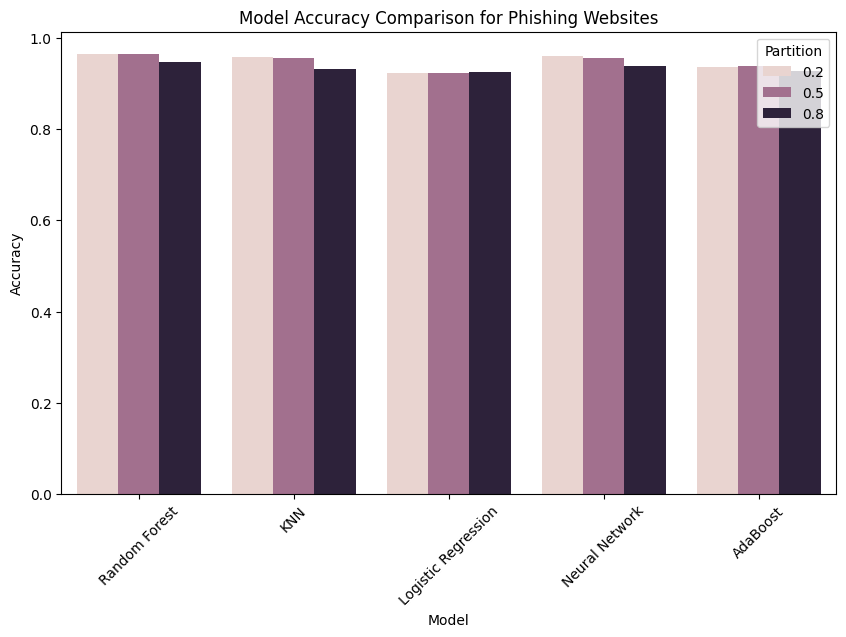

In [37]:

df_filtered = results_df[results_df["Dataset"] == "Phishing"]
plt.figure(figsize=(10, 6))
sns.barplot(data=df_filtered, x="Model", y="Accuracy", hue="Split")
plt.title(f"Model Accuracy Comparison for Phishing Websites")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.legend(title="Partition")
plt.xticks(rotation=45)
plt.show()

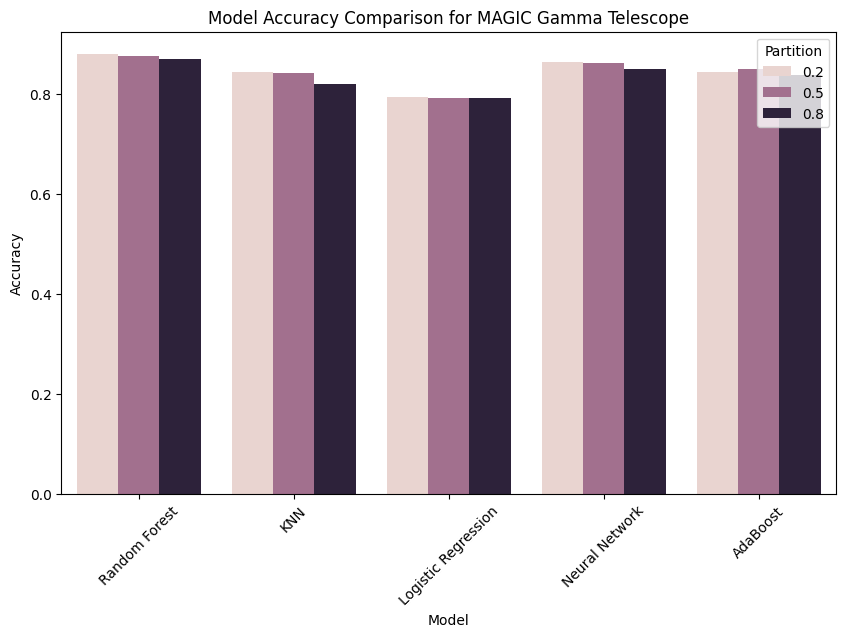

In [38]:

df_filtered = results_df[results_df["Dataset"] == "Telescope"]
plt.figure(figsize=(10, 6))
sns.barplot(data=df_filtered, x="Model", y="Accuracy", hue="Split")
plt.title(f"Model Accuracy Comparison for MAGIC Gamma Telescope")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.legend(title="Partition")
plt.xticks(rotation=45)
plt.show()

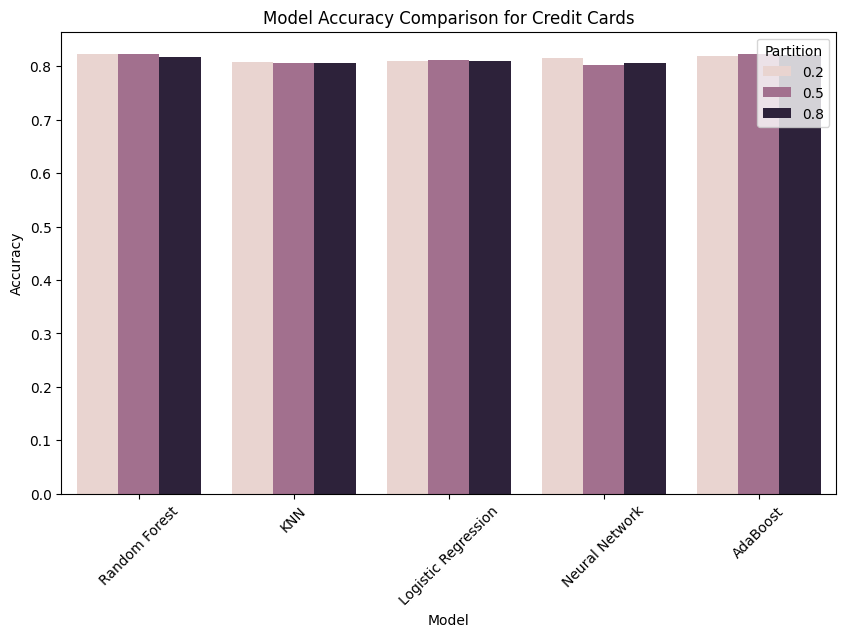

In [39]:

df_filtered = results_df[results_df["Dataset"] == "Credit Cards"]
plt.figure(figsize=(10, 6))
sns.barplot(data=df_filtered, x="Model", y="Accuracy", hue="Split")
plt.title(f"Model Accuracy Comparison for Credit Cards")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.legend(title="Partition")
plt.xticks(rotation=45)
plt.show()

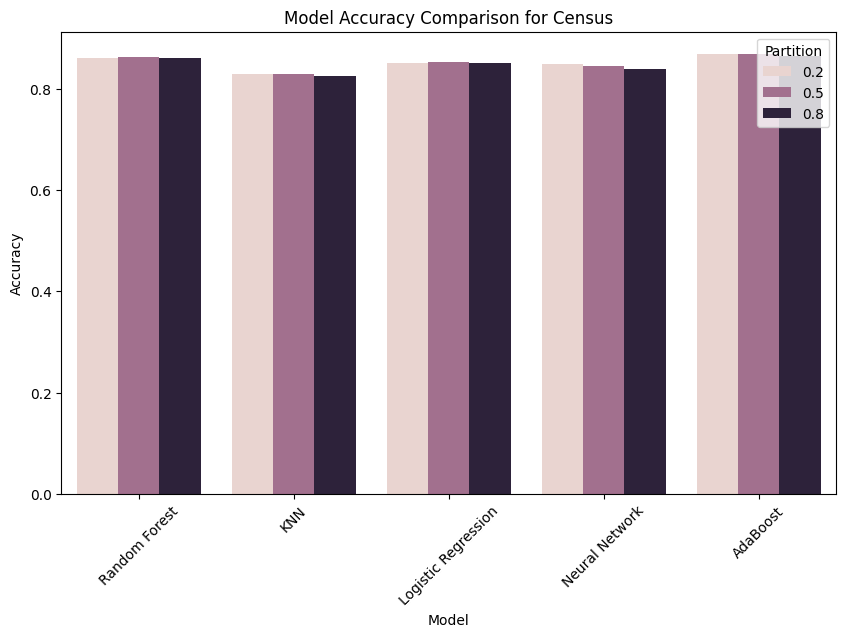

In [40]:

df_filtered = results_df[results_df["Dataset"] == "Census"]
plt.figure(figsize=(10, 6))
sns.barplot(data=df_filtered, x="Model", y="Accuracy", hue="Split")
plt.title(f"Model Accuracy Comparison for Census")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.legend(title="Partition")
plt.xticks(rotation=45)
plt.show()

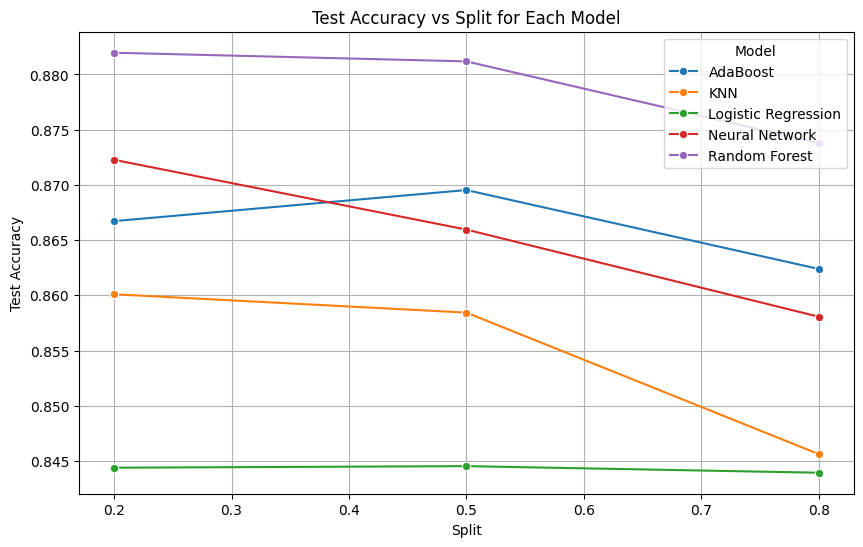

In [41]:
df_aggregated = results_df.groupby(["Split", "Model"]).mean(numeric_only=True).reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_aggregated, x="Split", y="Accuracy", hue="Model", marker="o")
plt.title("Test Accuracy vs Split for Each Model")
plt.ylabel("Test Accuracy")
plt.xlabel("Split")
plt.legend(title="Model")
plt.grid(True)
plt.show()

# Accuracy curve for each model

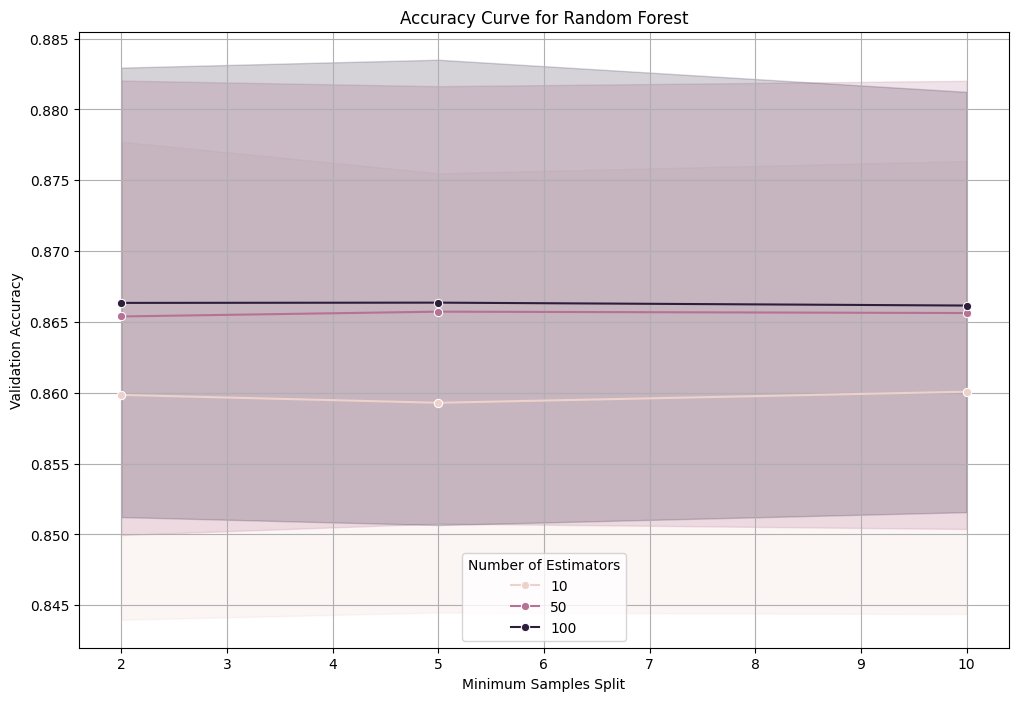

In [55]:
rf_data = detailed_df[detailed_df["Model"] == "Random Forest"]
rf_data = rf_data.assign(
    Min_Samples_Split=rf_data['Parameters'].apply(lambda x: x['classifier__min_samples_split']),
    N_Estimators=rf_data['Parameters'].apply(lambda x: x['classifier__n_estimators'])
)

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=rf_data,
    x="Min_Samples_Split",  
    y="Mean Test Accuracy", 
    hue="N_Estimators",  
    marker="o"
)

plt.title("Accuracy Curve for Random Forest")
plt.xlabel("Minimum Samples Split")
plt.ylabel("Validation Accuracy")
plt.legend(title="Number of Estimators")
plt.grid(True)
plt.show()


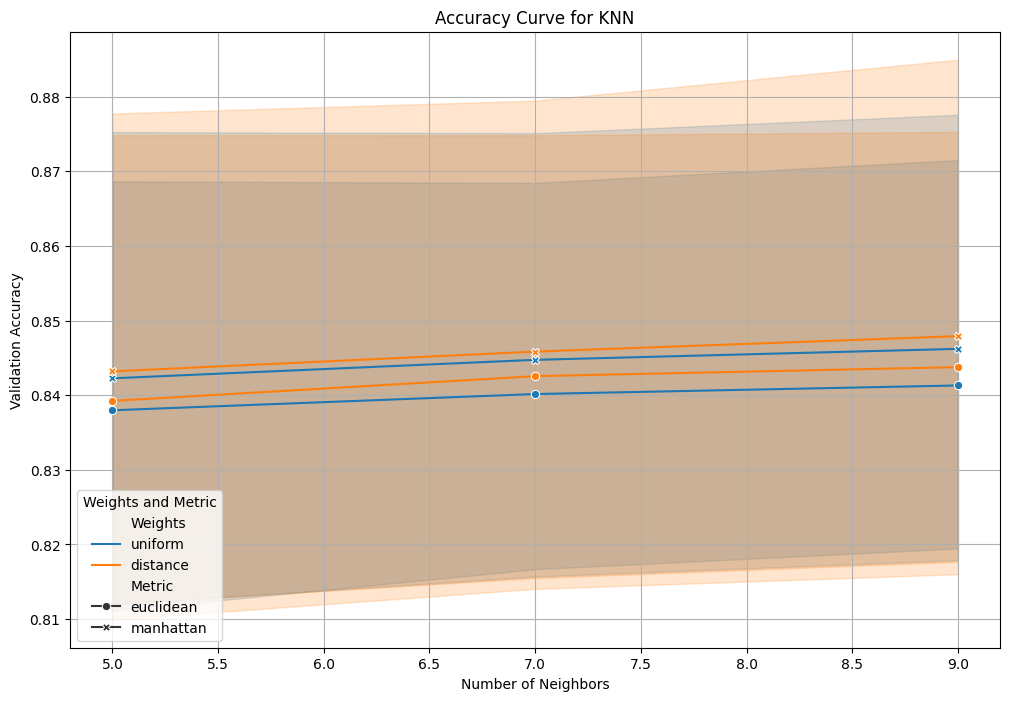

In [ ]:

knn_data = detailed_df[detailed_df["Model"] == "KNN"]
knn_data = knn_data.assign(
    N_Neighbors=knn_data['Parameters'].apply(lambda x: x['classifier__n_neighbors']),
    Weights=knn_data['Parameters'].apply(lambda x: x['classifier__weights']),
    Metric=knn_data['Parameters'].apply(lambda x: x['classifier__metric'])
)
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=knn_data,
    x="N_Neighbors",  
    y="Mean Test Accuracy",  
    hue="Weights",  
    style="Metric",  
    markers=True,
    dashes=False
)
plt.title("Accuracy Curve for KNN")
plt.xlabel("Number of Neighbors")
plt.ylabel("Validation Accuracy")
plt.legend(title="Weights and Metric", loc="best")
plt.grid(True)
plt.show()


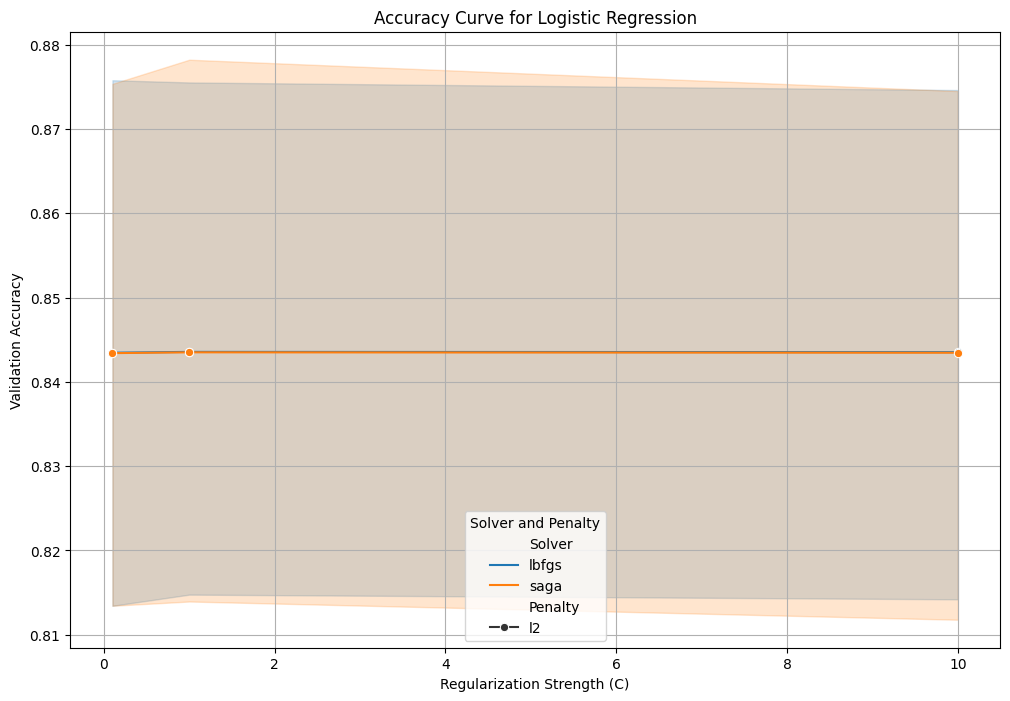

In [47]:

log_reg_data = detailed_df[detailed_df["Model"] == "Logistic Regression"]

log_reg_data = log_reg_data.assign(
    C=log_reg_data['Parameters'].apply(lambda x: x['classifier__C']),
    Solver=log_reg_data['Parameters'].apply(lambda x: x['classifier__solver']),
    Penalty=log_reg_data['Parameters'].apply(lambda x: x['classifier__penalty'])
)

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=log_reg_data,
    x="C",  
    y="Mean Test Accuracy",  
    hue="Solver",  
    style="Penalty",  
    markers=True,
    dashes=False
)
plt.title("Accuracy Curve for Logistic Regression")
plt.xlabel("Regularization Strength (C)")
plt.ylabel("Validation Accuracy")
plt.legend(title="Solver and Penalty", loc="best")
plt.grid(True)
plt.show()


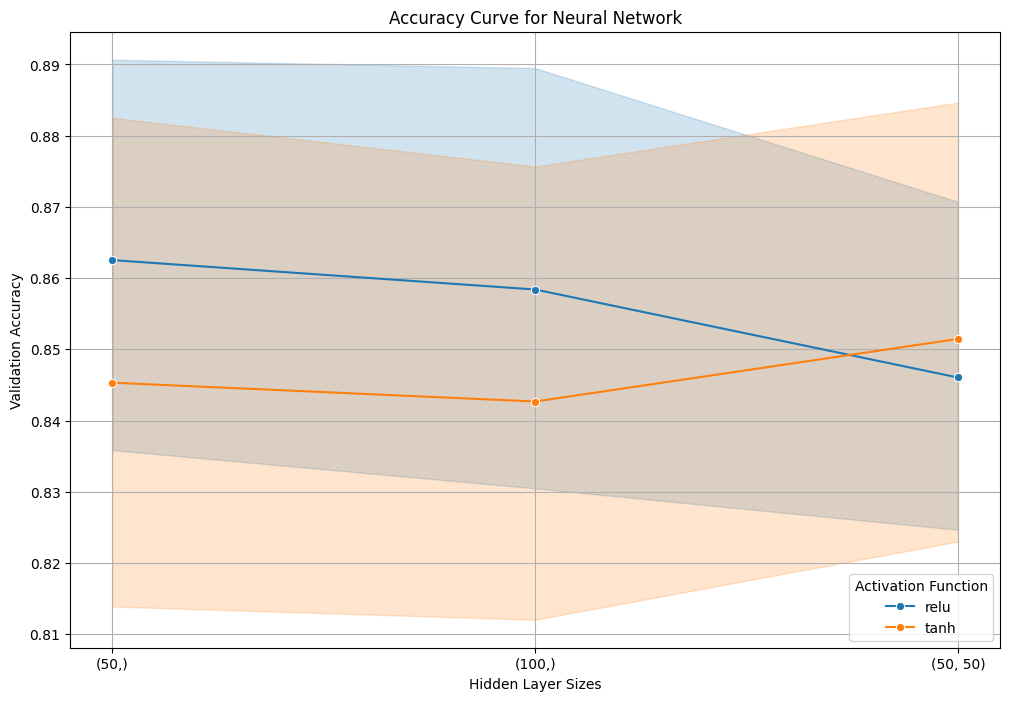

In [51]:

nn_data = detailed_df[detailed_df["Model"] == "Neural Network"]
nn_data = nn_data.assign(
    Hidden_Layers=nn_data['Parameters'].apply(lambda x: str(x['classifier__hidden_layer_sizes'])),  
    Activation=nn_data['Parameters'].apply(lambda x: x['classifier__activation'])
)
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=nn_data,
    x="Hidden_Layers",  
    y="Mean Test Accuracy",  
    hue="Activation",  
    marker="o"
)
plt.title("Accuracy Curve for Neural Network")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("Validation Accuracy")
plt.legend(title="Activation Function", loc="best")
plt.grid(True)
plt.show()


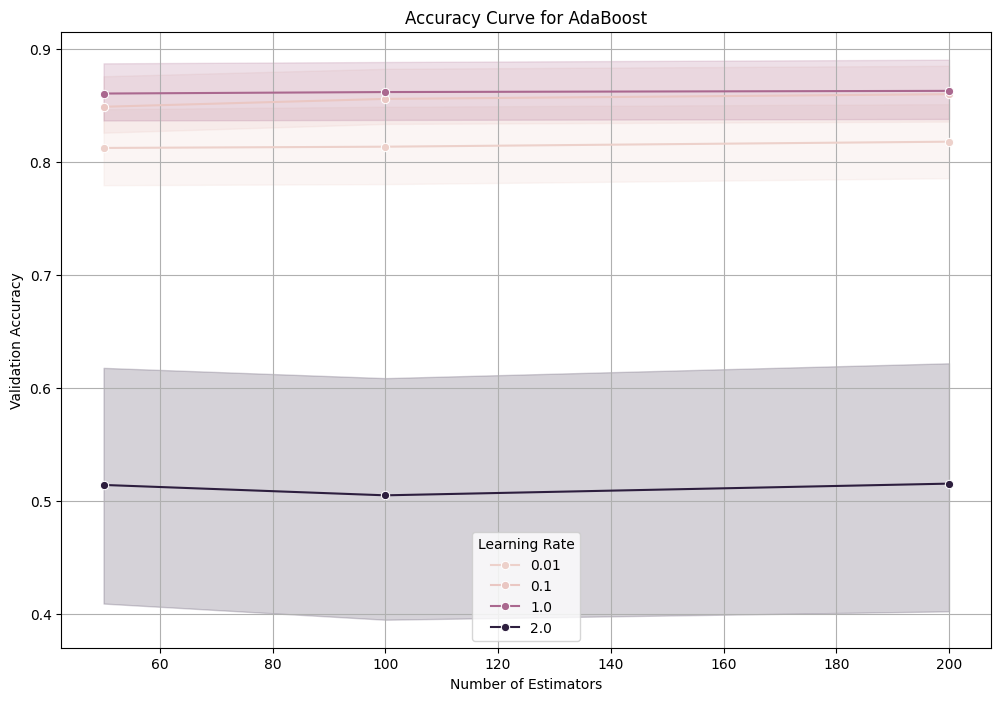

In [49]:

adaboost_data = detailed_df[detailed_df["Model"] == "AdaBoost"]

adaboost_data = adaboost_data.assign(
    N_Estimators=adaboost_data['Parameters'].apply(lambda x: x['classifier__n_estimators']),
    Learning_Rate=adaboost_data['Parameters'].apply(lambda x: x['classifier__learning_rate'])
)

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=adaboost_data,
    x="N_Estimators",  
    y="Mean Test Accuracy",  
    hue="Learning_Rate",  
    marker="o"
)
plt.title("Accuracy Curve for AdaBoost")
plt.xlabel("Number of Estimators")
plt.ylabel("Validation Accuracy")
plt.legend(title="Learning Rate", loc="best")
plt.grid(True)
plt.show()


# Heatmap for each model

In [54]:
rf_data.columns

Index(['Dataset', 'Split', 'Model', 'Parameters', 'Mean Train Accuracy',
       'Mean Test Accuracy', 'Rank Test Accuracy'],
      dtype='object')

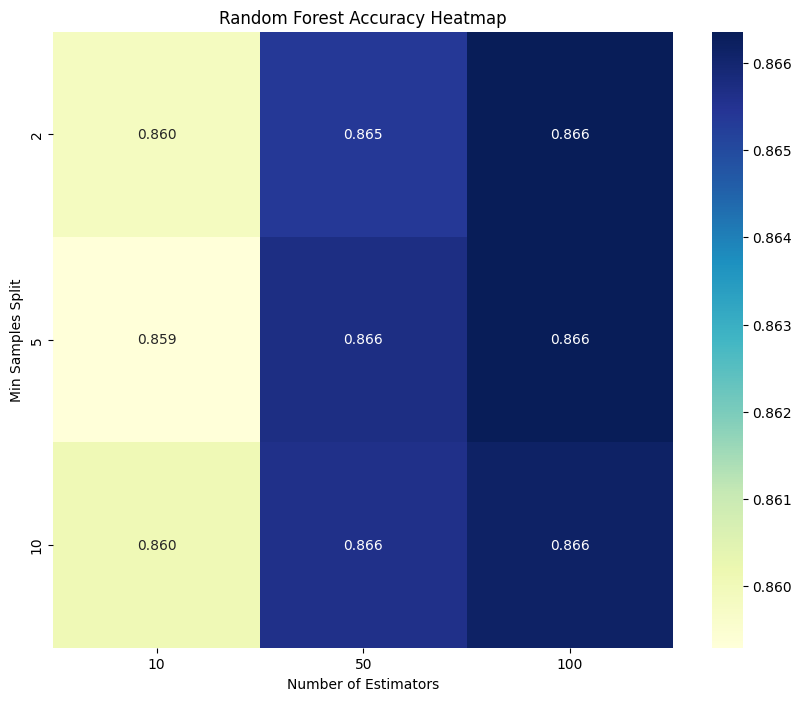

In [ ]:
rf_heatmap_data = rf_data.pivot_table(
    index="Min_Samples_Split",  
    columns="N_Estimators",    
    values="Mean Test Accuracy"
)


plt.figure(figsize=(10, 8))
sns.heatmap(
    rf_heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu"
)
plt.title("Random Forest Accuracy Heatmap")
plt.xlabel("Number of Estimators")
plt.ylabel("Min Samples Split")
plt.show()

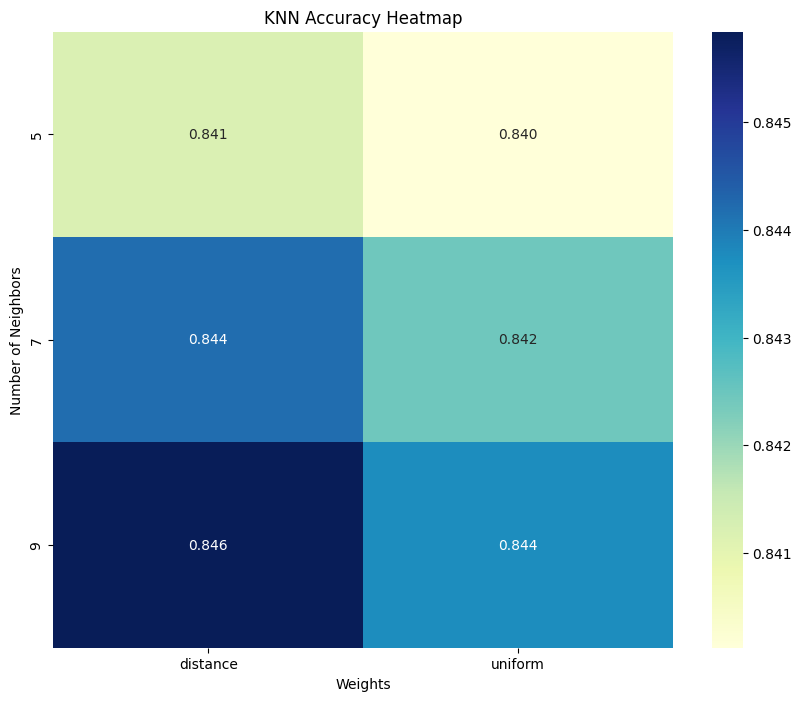

In [60]:
knn_heatmap_data = knn_data.pivot_table(
    index="N_Neighbors",  
    columns="Weights",    
    values="Mean Test Accuracy"
)


plt.figure(figsize=(10, 8))
sns.heatmap(
    knn_heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu"
)
plt.title("KNN Accuracy Heatmap")
plt.xlabel("Weights")
plt.ylabel("Number of Neighbors")
plt.show()


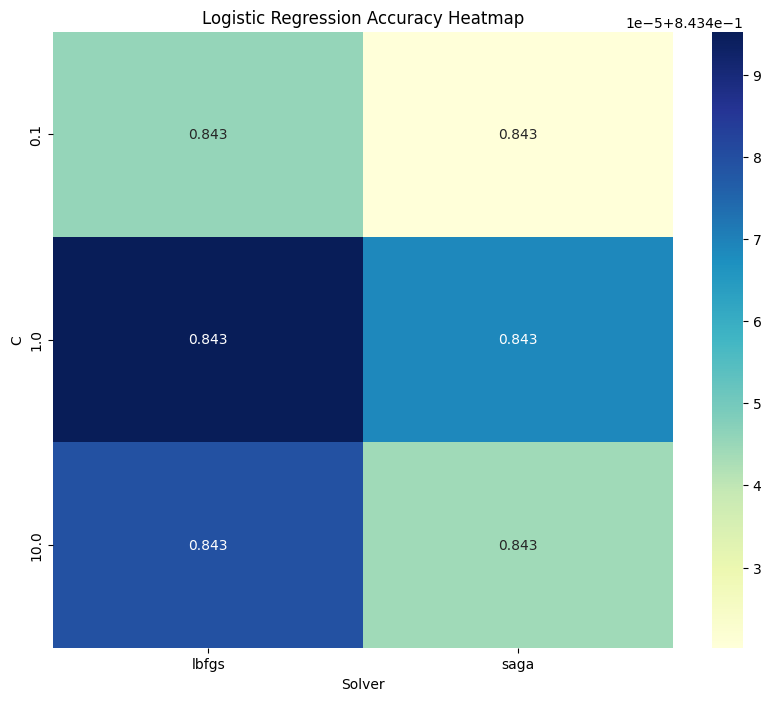

In [61]:
lr_heatmap_data = log_reg_data.pivot_table(
    index="C",  
    columns="Solver",  
    values="Mean Test Accuracy"
)


plt.figure(figsize=(10, 8))
sns.heatmap(
    lr_heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu"
)
plt.title("Logistic Regression Accuracy Heatmap")
plt.xlabel("Solver")
plt.ylabel("C")
plt.show()

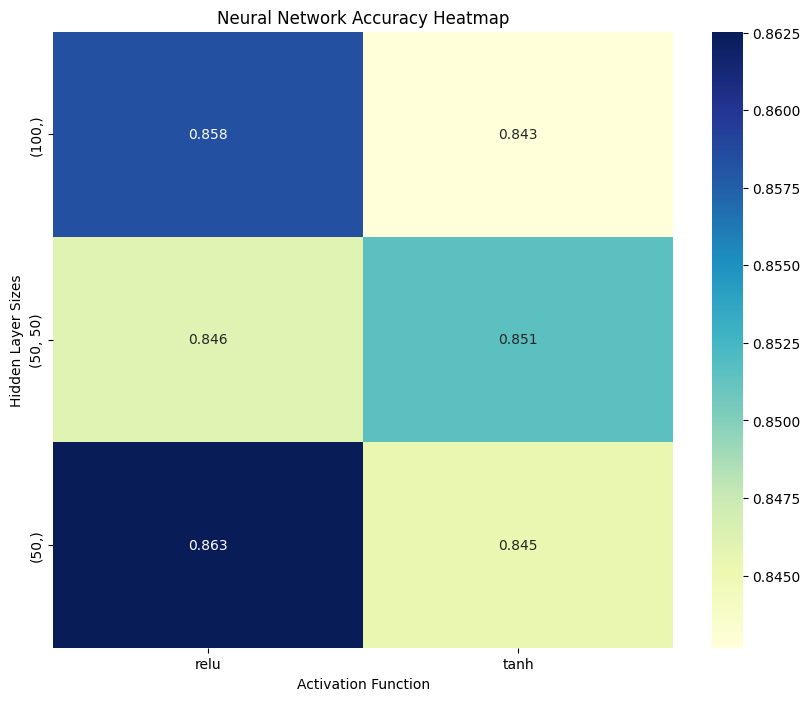

In [62]:
nn_heatmap_data = nn_data.pivot_table(
    index="Hidden_Layers", 
    columns="Activation",  
    values="Mean Test Accuracy"
)


plt.figure(figsize=(10, 8))
sns.heatmap(
    nn_heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu"
)
plt.title("Neural Network Accuracy Heatmap")
plt.xlabel("Activation Function")
plt.ylabel("Hidden Layer Sizes")
plt.show()

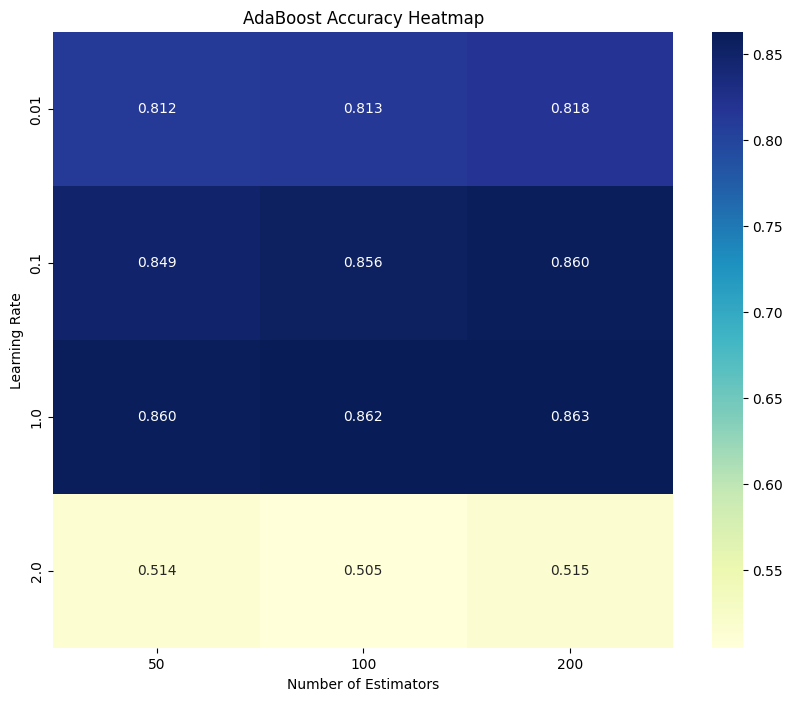

In [ ]:
ab_heatmap_data = adaboost_data.pivot_table(
    index="Learning_Rate",  
    columns="N_Estimators",  
    values="Mean Test Accuracy"
)


plt.figure(figsize=(10, 8))
sns.heatmap(
    ab_heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu"
)
plt.title("AdaBoost Accuracy Heatmap")
plt.xlabel("Number of Estimators")
plt.ylabel("Learning Rate")
plt.show()